In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2

In [2]:
# Finds largest contour within bounding box
def findROIContour(thresh, bbox):
    bbox = map(int, bbox)
    x, y, w, h = bbox
    # ROI based off bounding box coordinates
    thresh_roi = thresh[y:y+h, x:x+w]
    # Mask of black pixels so only ROI is searched for contour
    mask = np.zeros((thresh.shape[0], thresh.shape[1]), np.uint8)
    mask[y:y+h, x:x+w] = thresh_roi
    
    # Taken from: https://stackoverflow.com/questions/54615166/find-the-biggest-contour-opencv-python-getting-errors
    contours = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    contour_areas = [(cv2.contourArea(contour), contour) for contour in contours[0]]
    # If no contour, return None
    #print(contour_areas)
    if contour_areas is None or len(contour_areas)==0:
        final_c = [None, None]
    else:
        final_c = max(contour_areas, key=lambda x: x[0]) # Find largest contour in box
    return final_c[1]

# Find Centre coordinates of contour
def getContourMoment(contour):
    m = cv2.moments(contour)
    # Find Contour centre 
    x = m['m10'] / m['m00']
    y = m['m01'] / m['m00']
    return int(x), int(y) 

# Finds the full contour based on bounding box ROI
def findFullContour(thresh, centre):
    x, y = centre
    # Find all contours in image
    contours = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    # Return contour that centre belongs to
    for c in contours[0]:
        dist = cv2.pointPolygonTest(c, (x,y), False)
        if dist == 1.0:
            final_contour = c
            #print('Contour Found')
            #if cv2.contourArea(c) > size * 1.5:
            #    pass
            break
        else:
            final_contour = findROIContour(thresh, (x-10, y-10, 20, 20))
    #print(final_contour)
    return final_contour

# Fits a bounding box tightly around the contour
def getFittedBox(contour):
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    return rect, box

# Converts a fitted bounding box to a straight one with no rotation 
def rotatedBoxConverter(box):
    box_t = np.array(box).T
    x, y = min(box_t[0]), min(box_t[1])
    w, h = max(box_t[0]) - x, max(box_t[1]) - y
    return x, y, w, h

# Calculate avg area of box
def avgArea(box, total, count):
    x, y, w, h = box
    total += w * h
    avg = total / count
    return total, avg




### Remove Duplicates

In [3]:
waggle_df = pd.read_pickle('WaggleDetections-Bees10.pkl')
#waggle_df.drop(['index'], axis=1, inplace=True)
#waggle_df.reset_index(inplace=True)
# Sort by cluster and then frame so the dataset is ordered in blocks of clusters
waggle_df = waggle_df.sort_values(by=['Cluster', 'frame']).reset_index().drop(['index', 'level_0'], axis=1).reset_index()

In [4]:
waggle_df[waggle_df['Cluster']==2]

,index,x,y,frame,size,contour,Cluster
65,65,1230,317,111,331.5,"[[[1223, 289]], [[1224, 290]], [[1225, 291]], ...",2
66,66,1230,327,123,287.0,"[[[1263, 305]], [[1263, 306]], [[1263, 307]], ...",2
67,67,1248,311,125,351.5,"[[[1244, 282]], [[1243, 283]], [[1242, 283]], ...",2
68,68,1239,295,126,292.0,"[[[1244, 282]], [[1243, 283]], [[1242, 283]], ...",2
69,69,1261,328,127,258.5,"[[[1262, 316]], [[1261, 317]], [[1261, 318]], ...",2
70,70,1239,302,127,535.5,"[[[1237, 281]], [[1236, 282]], [[1236, 283]], ...",2
71,71,1261,328,128,259.0,"[[[1262, 316]], [[1261, 317]], [[1261, 318]], ...",2
72,72,1242,305,128,452.5,"[[[1244, 285]], [[1244, 286]], [[1244, 287]], ...",2
73,73,1242,304,129,498.5,"[[[1235, 280]], [[1234, 281]], [[1234, 282]], ...",2
74,74,1242,300,130,408.0,"[[[1235, 282]], [[1234, 283]], [[1233, 283]], ...",2


In [5]:
# All rows duplicated on frame and cluster
dup = waggle_df[waggle_df.duplicated(subset=['frame', 'Cluster'], keep=False)] # Returns all rows that match on frame and cluster
dup

# All non duplicated rows
non_dup = waggle_df[~waggle_df.duplicated(subset=['frame', 'Cluster'], keep=False)] # Returns all rows that match on frame and cluster

In [6]:
dup

,index,x,y,frame,size,contour,Cluster
1,1,1076,261,3,405.0,"[[[1070, 233]], [[1069, 234]], [[1069, 235]], ...",0
2,2,1041,250,3,443.0,"[[[1028, 233]], [[1027, 234]], [[1026, 235]], ...",0
5,5,1037,247,10,358.5,"[[[1052, 226]], [[1051, 227]], [[1050, 227]], ...",0
6,6,1075,243,10,689.5,"[[[1058, 210]], [[1057, 211]], [[1056, 212]], ...",0
7,7,1075,254,11,627.0,"[[[1074, 231]], [[1073, 232]], [[1073, 233]], ...",0
...,...,...,...,...,...,...,...
6740,6740,1237,465,13566,697.5,"[[[1254, 424]], [[1254, 425]], [[1254, 426]], ...",275
6751,6751,1228,495,13599,443.5,"[[[1221, 468]], [[1221, 469]], [[1221, 470]], ...",276
6752,6752,1205,483,13599,274.0,"[[[1214, 467]], [[1213, 468]], [[1212, 468]], ...",276
6759,6759,1227,513,13612,298.0,"[[[1220, 486]], [[1221, 486]], [[1222, 487]], ...",276


In [7]:
a = dup.index.values
b = dup.index.values - 1 # Rows before duplicate
c = dup.index.values + 1 # Rows after duplicate

# Concatenate removing duplicate indices
idx = np.unique(np.concatenate((a, b, c)))

df = waggle_df[waggle_df.index.isin(idx)]
df['Cluster'].value_counts()

123    53
86     52
70     50
275    42
26     42
       ..
64      1
259     1
47      1
53      1
132     1
Name: Cluster, Length: 202, dtype: int64

In [8]:
df[df['Cluster']==2]

,index,x,y,frame,size,contour,Cluster
68,68,1239,295,126,292.0,"[[[1244, 282]], [[1243, 283]], [[1242, 283]], ...",2
69,69,1261,328,127,258.5,"[[[1262, 316]], [[1261, 317]], [[1261, 318]], ...",2
70,70,1239,302,127,535.5,"[[[1237, 281]], [[1236, 282]], [[1236, 283]], ...",2
71,71,1261,328,128,259.0,"[[[1262, 316]], [[1261, 317]], [[1261, 318]], ...",2
72,72,1242,305,128,452.5,"[[[1244, 285]], [[1244, 286]], [[1244, 287]], ...",2
73,73,1242,304,129,498.5,"[[[1235, 280]], [[1234, 281]], [[1234, 282]], ...",2


In [9]:
pts = df[['index', 'x','y','frame']].values

#pts = pts[np.argsort(pts[:, -1], axis = 0)]    # to sort about last column if not sorted
# Returns indices of duplicates
same_pts = [np.argwhere(i[0] == pts[:, -1]) for i in np.array(np.unique(pts[:, -1], return_counts=True)).T if i[1]>=2]
remove_row = []
for i in same_pts:
    dist = []
    pre = min(i)-1
    post = max(i)+1
    for j in i:
        # Euclidean distance from duplicate points and the point in the frame before and after 
        dist_pre = np.sqrt((pts[pre, 1]-pts[j, 1])**2 + (pts[pre, 2]-pts[j, 2])**2)
        dist_post = np.sqrt((pts[post, 1]-pts[j, 1])**2 + (pts[post, 2]-pts[j, 2])**2)
        dist.append(dist_pre + dist_post)
    remove_row.append(i[np.argmax(dist)][0])
# Returns pts with furthest duplicates removed
final_pts = np.delete(pts, remove_row, axis = 0)

In [10]:
# Concatenate final_pts index with non_duplicate index, removing unique values
final_idx = np.unique(np.concatenate((non_dup.index.values, final_pts[:, 0])))

In [11]:
df = waggle_df[waggle_df['index'].isin(final_idx)]

In [12]:
df['Cluster'].value_counts()
#df[df['Cluster']==229]

72     51
275    48
82     48
123    47
85     45
       ..
46     10
136    10
262     9
257     8
75      5
Name: Cluster, Length: 277, dtype: int64

In [13]:
df[df['Cluster']==2]

,index,x,y,frame,size,contour,Cluster
65,65,1230,317,111,331.5,"[[[1223, 289]], [[1224, 290]], [[1225, 291]], ...",2
66,66,1230,327,123,287.0,"[[[1263, 305]], [[1263, 306]], [[1263, 307]], ...",2
67,67,1248,311,125,351.5,"[[[1244, 282]], [[1243, 283]], [[1242, 283]], ...",2
68,68,1239,295,126,292.0,"[[[1244, 282]], [[1243, 283]], [[1242, 283]], ...",2
69,69,1261,328,127,258.5,"[[[1262, 316]], [[1261, 317]], [[1261, 318]], ...",2
72,72,1242,305,128,452.5,"[[[1244, 285]], [[1244, 286]], [[1244, 287]], ...",2
73,73,1242,304,129,498.5,"[[[1235, 280]], [[1234, 281]], [[1234, 282]], ...",2
74,74,1242,300,130,408.0,"[[[1235, 282]], [[1234, 283]], [[1233, 283]], ...",2
75,75,1256,308,133,281.0,"[[[1228, 290]], [[1229, 290]], [[1230, 290]], ...",2
76,76,1250,295,140,318.0,"[[[1242, 270]], [[1241, 271]], [[1240, 272]], ...",2


### Fill Missing

In [25]:
# Prevent tracking update failures
def anchorBox(box, prev_box, avg):
    global counter
    x0, y0, w0, h0 = prev_box
    x, y, w, h = box
    
    # If bounding box is too far from previous box
    #if abs(x - x0) > w0/2 and abs(y - y0) > h0/2:
    if abs(x - x0) > w0/2 or abs(y - y0) > h0/2: # CHANGED FOR TESTING ON BEES10 2
        print('Box Lost')
        success = False
    # If bounding box is too large
    elif abs(w * h) > (avg * 2):
        print('Box Lost (Expanded)')
        print(str(counter))
        success = 'Expanded'
    # If bounding box is too small
    elif abs(w * h) < (avg / 2):
        print('Box Lost (Shrunk)')
        print(str(counter))
        success = 'Shrunk'
    # prev_box only updated if box found
    else:
        print('Box Found')
        prev_box = box 
        success = True

    return success, prev_box

def expandBox(img, bbox):
    contour = None
    x, y, w, h = bbox
    x -= 10
    w += 20
    y -= 10
    h += 20
    bbox = (x, y, w, h)
    print(bbox)
    contour = findROIContour(img, bbox)
    return bbox, contour

# Find which way object is facing by the direction in which bounding box moves, to be coupled with angle of bounding rect
def moveDirection(prev_bbox, bbox):
    x, y, w, h = bbox
    x0, y0, w0, h0 = prev_bbox
    
    xd = x - x0
    # if xd is negative, moved west, if xd is positive, moved east
    yd = y - y0
    # if yd is negative, moved north, if yd is positive, moved south
    movement = (xd, yd)
    return movement

In [26]:
final_df = pd.DataFrame(columns=['x', 'y', 'frame', 'bbox', 'size', 'angle', 'cluster']) # maybe add direction change?

,index,x,y,frame,size,contour,Cluster
840,840,1237,273,1189,450.5,"[[[1241, 239]], [[1240, 240]], [[1239, 240]], ...",35
841,841,1238,282,1190,479.0,"[[[1238, 240]], [[1237, 241]], [[1236, 241]], ...",35
842,842,1234,271,1193,481.0,"[[[1235, 238]], [[1234, 239]], [[1233, 239]], ...",35
843,843,1234,267,1194,836.0,"[[[1237, 213]], [[1237, 214]], [[1237, 215]], ...",35
844,844,1233,260,1195,708.5,"[[[1239, 224]], [[1239, 225]], [[1238, 226]], ...",35
845,845,1231,256,1196,917.0,"[[[1224, 221]], [[1225, 222]], [[1225, 223]], ...",35
846,846,1231,248,1198,657.5,"[[[1247, 205]], [[1246, 206]], [[1245, 207]], ...",35
847,847,1228,255,1199,368.0,"[[[1230, 238]], [[1229, 239]], [[1228, 239]], ...",35
848,848,1230,259,1200,428.5,"[[[1230, 238]], [[1229, 239]], [[1228, 239]], ...",35
849,849,1227,245,1201,376.5,"[[[1241, 216]], [[1240, 217]], [[1239, 218]], ...",35


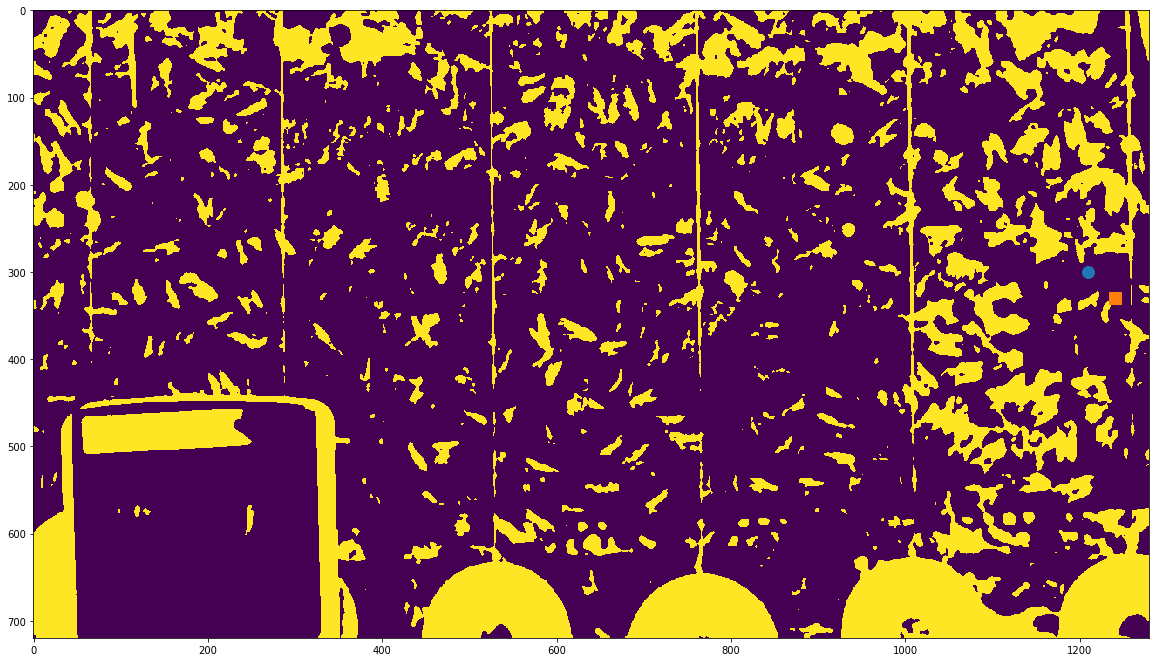

In [53]:
clust = df[df['Cluster']==35] # 1, 6
clust
cap = cv2.VideoCapture('Bees10.mov')
cap.set(1, 233)
_, frame = cap.read()
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (15,15), 1)
thresh = cv2.threshold(gray, 120, 220, cv2.THRESH_BINARY)[1]

plt.figure(figsize=(20,20))
plt.imshow(thresh)
plt.plot(1225-15, 315-15, marker='o', markersize=12)
plt.plot(1225+15, 315+15, marker='s', markersize=12)
clust

[[[1239  258]]

 [[1238  259]]

 [[1238  260]]

 [[1238  261]]

 [[1237  262]]

 [[1237  263]]

 [[1237  264]]

 [[1236  265]]

 [[1236  266]]

 [[1236  267]]

 [[1237  268]]

 [[1237  269]]

 [[1237  270]]

 [[1238  271]]

 [[1238  272]]

 [[1238  273]]

 [[1238  274]]

 [[1238  275]]

 [[1238  276]]

 [[1238  277]]

 [[1238  278]]

 [[1238  279]]

 [[1239  280]]

 [[1240  281]]

 [[1240  282]]

 [[1241  282]]

 [[1242  283]]

 [[1243  283]]

 [[1244  283]]

 [[1245  283]]

 [[1246  283]]

 [[1247  283]]

 [[1248  283]]

 [[1249  283]]

 [[1250  282]]

 [[1251  282]]

 [[1251  281]]

 [[1251  280]]

 [[1251  279]]

 [[1251  278]]

 [[1251  277]]

 [[1251  276]]

 [[1251  275]]

 [[1251  274]]

 [[1251  273]]

 [[1251  272]]

 [[1251  271]]

 [[1251  270]]

 [[1251  269]]

 [[1251  268]]

 [[1251  267]]

 [[1251  266]]

 [[1251  265]]

 [[1251  264]]

 [[1251  263]]

 [[1251  262]]

 [[1251  261]]

 [[1251  260]]

 [[1251  259]]

 [[1250  260]]

 [[1249  260]]

 [[1248  260]]

 [[1247 

-1

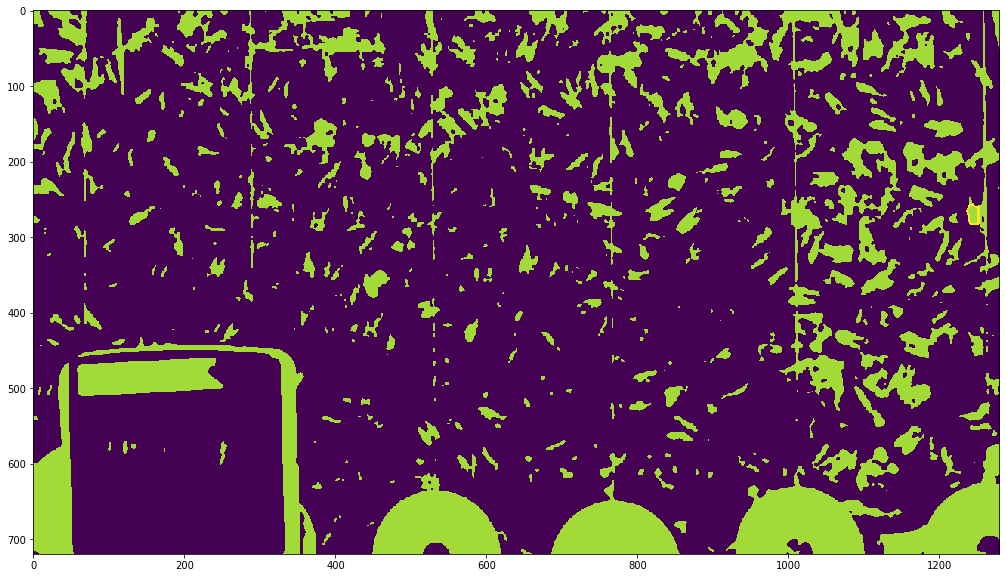

In [54]:
start = clust.iloc[0, :]['frame']
end = clust.iloc[-1, :]['frame']
cluster = clust.iloc[0, :]['Cluster']
# Get range of frames where waggle occurs
rang = np.arange(start, end, 1)
missing = list(set(rang)-set(clust.frame.values)) # Frames where waggle missing from df

counter = start
cap = cv2.VideoCapture('Bees10.mov')
cap.set(1, start)
ret, frame = cap.read()
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Preprocessing
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (15,15), 1)
thresh = cv2.threshold(gray, 120, 220, cv2.THRESH_BINARY)[1]
kernel = np.ones((2,2),np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
opening = cv2.erode(opening, kernel, iterations=1)

# Find contour bounding box
x, y = clust.iloc[0, :]['x'], clust.iloc[0]['y']
bbox = x-15, y-15, 30, 30

contour = findROIContour(opening, bbox)
print(contour)
if contour is None:
    print('Contour None')
    contour = findROIContour(thresh, bbox)
    opening = thresh # For findFullContour
plt.figure(figsize=(20,10))
cv2.drawContours(opening, contour, -1, (255,0,0), 2, 1)
plt.imshow(opening)
centre = getContourMoment(contour)
contour = findFullContour(opening, centre)
if cv2.contourArea(contour) > clust['size'].max():
    contour = findROIContour(opening, bbox)
    print(contour)
rect, box = getFittedBox(contour)
bbox = rotatedBoxConverter(box)
prev_bbox = bbox
avg = bbox[2]*bbox[3]
total = avg
print(avg)

# Create tracker 
print(frame)
tracker = cv2.TrackerCSRT_create()
tracker.init(frame, bbox)

rois = []

while counter < end:
    counter += 1 
    print(counter)
    ret, frame = cap.read()
    
    
    # Preprocessing
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (15,15), 1)
    thresh = cv2.threshold(gray, 120, 220, cv2.THRESH_BINARY)[1]
    kernel = np.ones((2,2),np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    opening = cv2.erode(opening, kernel, iterations=1)

    # If frame not in df, use tracker to fill in the missing
    if counter in missing:
        print('Missing')
        # update tracker
        ret, bbox = tracker.update(frame)
        # Prevent tracking errors
        found, prev_bbox = anchorBox(bbox, prev_bbox, avg)
        if found is 'Shrunk':
            print('Box Shrunk')
            bbox, contour = expandBox(opening, bbox)
        elif found is False:
            print('false')
            bbox, contour = expandBox(opening, prev_bbox)
    # If frame is in df, use df coordinates
    else:
        print('In DF')
        waggle = clust[clust['frame']==counter].reset_index()
        x, y = waggle.loc[0, 'x'], waggle.loc[0, 'y']
        bbox = x-15, y-15, 30, 30
    
    # If bbox goes out of frame, end tracking 
    if bbox[0] < 0 or bbox[0] > width or bbox[1] < 0 or bbox[1] > height:
        print('Object out of bounds')
        final_df.loc[len(final_df)] = 0
        break        

    # Find contour from bbox and get information
    contour = findROIContour(opening, bbox)
    if contour is None:
        print('Contour None')
        contour = findROIContour(thresh, bbox)
        opening = thresh # For findFullContour
    # If contour still None, dilate
    i = 0
    while contour is None or cv2.contourArea(contour) <= 80: # or too small
        print('Contour still none')
        dilate = cv2.dilate(opening, kernel, iterations=1)
        contour = findROIContour(dilate, bbox)
        opening = dilate # For findFullContour
        i += 1
        if i > 40:
            break
    roi_contour = contour # Save for use in findFullContour failure
    # Readjust centre and find full contour outside ROI
    centre = getContourMoment(contour)
    contour = findFullContour(opening, centre)
    # If contour too large, erode image, then use ROI
    while cv2.contourArea(contour) > clust['size'].max():
        opening = cv2.erode(opening, kernel, iterations = 1)
        bbox = centre[0]-15, centre[1]-15, 30, 30
        contour = findROIContour(opening, bbox)
        if contour is None:
            contour = roi_contour
            break
    rect, box = getFittedBox(contour)
    bbox = rotatedBoxConverter(box)
    if bbox[2]*bbox[3] > avg*1.5:
        print('Too Large')
        # Re-centre ROI to contour, and get bbox on cropped contour
        x, y = centre 
        bbox = x-15, y-15, 30, 30
        contour = findROIContour(opening, bbox)
        rect, box = getFittedBox(contour)
        print(rect[-1])
        bbox = rotatedBoxConverter(box)
    
    angle = rect[-1]
    size = cv2.contourArea(contour)
        
    # If next frame is missing data, initialise tracker on bounding box
    if counter not in missing and counter + 1 in missing:
        print('c')
        # find contour
        tracker = cv2.TrackerCSRT_create()
        tracker.init(frame, bbox)
        
    
    # VISUALS    
    if ret:
    # Tracking success
        p1 = (int(bbox[0]), int(bbox[1]))
        p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
        cv2.rectangle(frame, p1, p2, (255, 0, 0), 2, 1)
        cv2.rectangle(opening, p1, p2, (255, 0, 0), 2, 1)
    else:
        cv2.putText(frame, "Tracking failure detected", (100, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)
    cv2.imshow("Tracking", frame)
    cv2.imshow("Threshold", opening)
    cv2.waitKey(100)
    
    final_df.loc[len(final_df)] = [centre[0], centre[1], counter, box, size, angle, cluster]
    
    movement = moveDirection(prev_bbox, bbox) # Track direction of box movement
    prev_bbox = bbox
    total, avg = avgArea(bbox, total, (counter-start)) # Track avg size of bounding box

    
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

In [44]:
bbox

(1197.7342529296875,
 -2.7161245346069336,
 28.431371688842773,
 29.41176414489746)

In [ ]:
from math import cos, sin
cols = (len(final_df['bbox']) // 10) + 1
plt.figure(figsize=(40, 20))

for i in range(0, len(final_df['bbox'])):
    x = [final_df.loc[i, 'bbox'][0][0], final_df.loc[i, 'bbox'][1][0]]
    y = [final_df.loc[i, 'bbox'][0][1], final_df.loc[i, 'bbox'][1][1]]
    
    angle = final_df.loc[i, 'angle']
    x, y = final_df.loc[i, 'bbox'][0]
    x1, y1 = x + 50 * cos(angle), y + 50 * sin(angle)


    # Setting the values for all axes.
    plt.subplot(cols, 10, i+1)
    plt.plot((x, x1), (y, y1), linewidth=5)
    #plt.xlim(1150, 1250)
    #plt.ylim(250, 400)
    

#for box in final_df['bbox']

The above is not the perfect way of displaying angles, as it does not show the intricacies of the angles throughout the waggle run. However, something like this where it shows the gradient as either positive or negative allows us to see the frequency of the bees waggle, demonstrating the intensity of the waggle run.

~28 direction changes over 52 frames

25 FPS, = ~13.5 waggles per second 

This is in line with research that the bee waggles at 13-15Hz https://www.beeculture.com/a-closer-look-waggle-dances/#:~:text=2013

In [18]:
cap = cv2.VideoCapture('Bees10.mov')
fps = cap.get(cv2.CAP_PROP_FPS)
fps

25.0

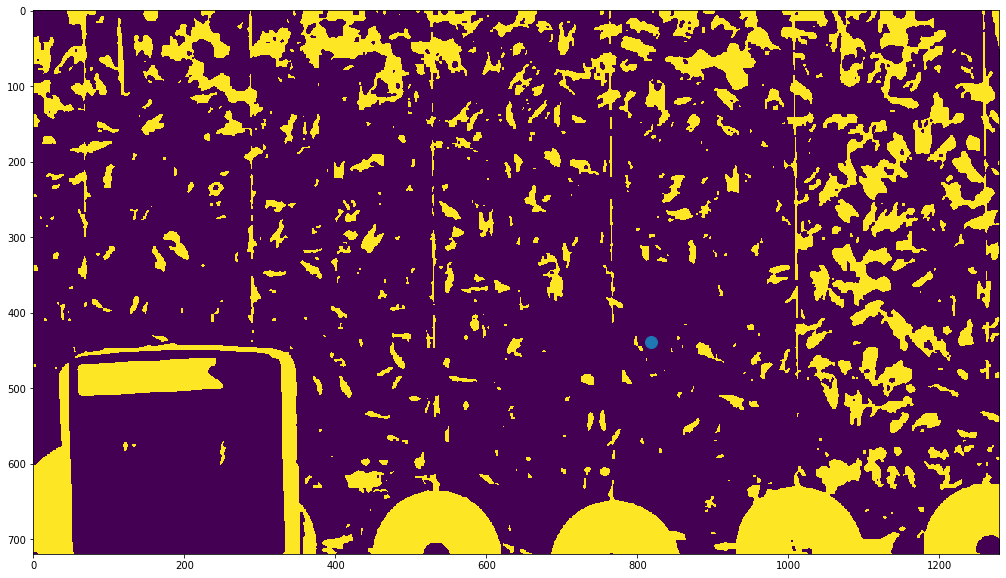

In [19]:
cap.set(1, 71)
ret, frame = cap.read()

# Preprocessing
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (15,15), 1)
#thresh = cv2.threshold(gray, 130, 220, cv2.THRESH_BINARY)[1]
thresh = cv2.threshold(gray, 120, 220, cv2.THRESH_BINARY)[1]
kernel = np.ones((2,2),np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)
opening = cv2.erode(opening, kernel, iterations=1)
#opening = cv2.dilate(thresh, kernel, iterations=2)


plt.figure(figsize=(20,10))
plt.imshow(opening)
plt.plot(818, 439, marker='o', markersize=12)

In [20]:
clust[clust['frame']==223]
clust

,index,x,y,frame,size,contour,Cluster
39,39,1213,25,73,250.5,"[[[1194, 10]], [[1194, 11]], [[1194, 12]], [[1...",1
40,40,1217,50,78,294.5,"[[[1216, 21]], [[1216, 22]], [[1217, 23]], [[1...",1
41,41,1221,47,79,404.5,"[[[1214, 8]], [[1214, 9]], [[1214, 10]], [[121...",1
43,43,1222,31,87,325.0,"[[[1222, 0]], [[1222, 1]], [[1222, 2]], [[1222...",1
44,44,1220,33,88,325.0,"[[[1235, 14]], [[1234, 15]], [[1233, 16]], [[1...",1
45,45,1202,35,93,344.0,"[[[1225, 14]], [[1225, 15]], [[1224, 16]], [[1...",1
46,46,1201,35,94,275.0,"[[[1225, 14]], [[1225, 15]], [[1224, 16]], [[1...",1
47,47,1201,31,96,372.5,"[[[1232, 0]], [[1232, 1]], [[1232, 2]], [[1232...",1
48,48,1203,34,97,467.5,"[[[1225, 9]], [[1225, 10]], [[1225, 11]], [[12...",1
49,49,1204,36,98,344.5,"[[[1224, 15]], [[1223, 16]], [[1222, 17]], [[1...",1


In [ ]:
missing = list(set(rang)-set(clust.frame.values))
missing